# Imports

In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import numpy as np
from matplotlib import pyplot as plt

data_path = "dataset/master_data/"

2022-10-19 18:36:51.336082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 18:36:51.444351: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-19 18:36:51.469094: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-19 18:36:52.048537: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [3]:
strategy = tf.distribute.MirroredStrategy()
strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2022-10-19 18:36:58.274092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-19 18:37:00.112075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 876 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2022-10-19 18:37:00.112832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 876 MB memory:  -> device: 1, name: GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-10-19 18:37:00.113481: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:

4

In [4]:
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

## Dataset Preparation

In [5]:
# data pipeline utils
data = tf.keras.utils.image_dataset_from_directory(data_path,
                                                   image_size = (512,512),
                                                   color_mode = 'rgb',
                                                   batch_size= 8)

Found 10950 files belonging to 2 classes.


In [6]:
# Generator to pull batches
data_iterator = data.as_numpy_iterator()

In [7]:
batch = data_iterator.next()

In [8]:
batch[0].shape

(8, 512, 512, 3)

In [9]:
batch[1]
# class 1 = Not Gan Generated
# Class 2 = Gan Generated

array([0, 1, 0, 1, 0, 0, 1, 1], dtype=int32)

In [10]:
# Reduce it to [0,1] as we load the data pipeline
# x - images , y - labels
data = data.map(lambda x,y: (x/255,y))

In [11]:
data.as_numpy_iterator().next()

(array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          [4.61473642e-03, 4.61473642e-03, 4.61473642e-03],
          [1.42271752e-02, 1.42271752e-02, 1.42271752e-02],
          ...,
          [3.92156886e-03, 7.84313772e-03, 0.00000000e+00],
          [3.92156886e-03, 7.84313772e-03, 0.00000000e+00],
          [3.92156886e-03, 7.84313772e-03, 0.00000000e+00]],
 
         [[5.94362756e-03, 5.94362756e-03, 5.94362756e-03],
          [7.41096959e-03, 7.41096959e-03, 7.41096959e-03],
          [1.04674250e-02, 1.04674250e-02, 1.04674250e-02],
          ...,
          [2.43566185e-03, 6.35723025e-03, 0.00000000e+00],
          [2.43566185e-03, 6.35723025e-03, 0.00000000e+00],
          [2.43566185e-03, 6.35723025e-03, 0.00000000e+00]],
 
         [[1.51348040e-02, 1.51348040e-02, 1.51348040e-02],
          [1.17350407e-02, 1.17350407e-02, 1.17350407e-02],
          [4.65337699e-03, 4.65337699e-03, 4.65337699e-03],
          ...,
          [1.37867653e-04, 4.05943627e-03, 0.0000

# Split the data

In [12]:
len(data) # Num of batches

1369

In [13]:
train_size = int(len(data)*.7)  
val_size = int(len(data)*.2) 
test_size = int(len(data)*.1)

In [14]:
print(train_size)
print(val_size)
print(test_size)
print(train_size + val_size + test_size)

958
273
136
1367


In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [16]:
print(len(train))
print(len(val))
print(len(test))

958
273
136


In [17]:
train2 = train.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val2 = val.batch(BATCH_SIZE)

# Visualise the images in the batches

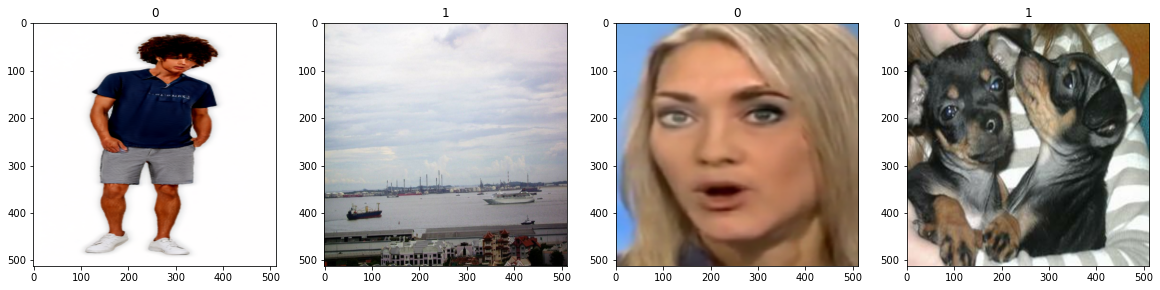

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 0 --> fake
# 1 --> real

# InceptionResnet Model

In [20]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input

def get_model():
    inception_model = InceptionResNetV2(include_top = False,
                          weights='imagenet',
                          input_shape = (512,512,3))
    model = models.Sequential()
    model.add(inception_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

    return model

In [22]:
with strategy.scope():
    gpu_model = get_model()
    print(gpu_model.summary())
    hist = gpu_model.fit(train2, epochs=5, validation_data=val2)

2022-10-19 18:43:40.904346: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38MiB (rounded to 3538944)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-10-19 18:43:40.904463: I tensorflow/core/common_runtime/bfc_allocator.cc:1033] BFCAllocator dump for GPU_0_bfc
2022-10-19 18:43:40.904496: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (256): 	Total Chunks: 488, Chunks in use: 488. 122.0KiB allocated for chunks. 122.0KiB in use in bin. 65.3KiB client-requested in use in bin.
2022-10-19 18:43:40.904514: I tensorflow/core/common_runtime/bfc_allocator.cc:1040] Bin (512): 	Total Chunks: 292, Chunks in use: 292. 198.5KiB allocated for chunks. 198.5KiB in use in bin. 189.5KiB client-requested in use in bin.
2022-10-19 18:43:40.904529:

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

# PlotPerformance

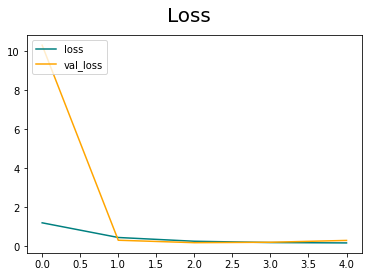

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal' ,label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange' ,label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

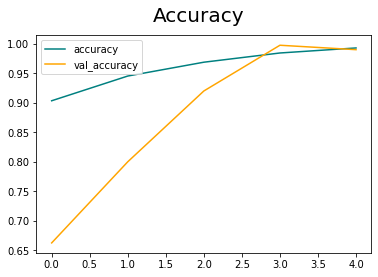

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange' ,label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [23]:
def memory():
    import os
    import psutil
    pid = os.getpid()
    py = psutil.Process(pid)
    memoryUse = py.memory_info()[0]/2.**30  # memory use in GB...I think
    print('memory use:', memoryUse)

In [31]:
tf.keras.backend.clear_session()

In [32]:
memory()

memory use: 3.2399444580078125


In [33]:
from numba import cuda
cuda.select_device(0)
cuda.close()

: 